In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.decomposition as skde
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['sample_submission.csv', 'test.csv', 'train.csv']


Import Datasets****


In [2]:
#import required datasets
test_data = pd.read_csv("../input/test.csv")
train_data= pd.read_csv("../input/train.csv")
train_data.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


**Explore Datasets**
- View Data information
- Check for missing values
- Check correlation 
- Visualize class distribution

(200000, 202) (200000, 201)
False False
           target     var_0     var_1    ...      var_197   var_198   var_199
target   1.000000  0.052390  0.050343    ...    -0.035303 -0.053000  0.025434
var_0    0.052390  1.000000 -0.000544    ...    -0.000753 -0.005776  0.003850
var_1    0.050343 -0.000544  1.000000    ...    -0.004157 -0.004861  0.002287
var_2    0.055870  0.006573  0.003980    ...     0.001078 -0.000877  0.003855
var_3    0.011055  0.003801  0.000010    ...     0.001164 -0.001651  0.000506
var_4    0.010915  0.001326  0.000303    ...    -0.000046 -0.001821 -0.000786
var_5    0.030979  0.003046 -0.000902    ...    -0.000535 -0.000953  0.002767
var_6    0.066731  0.006983  0.003258    ...    -0.003565 -0.003025  0.006096
var_7   -0.003025  0.002429  0.001511    ...     0.003466  0.000650 -0.001457
var_8    0.019584  0.004962  0.004098    ...    -0.004583  0.002950  0.000854
var_9   -0.042805 -0.002613 -0.000832    ...     0.003701  0.002343  0.001070
var_10  -0.002213  0.000

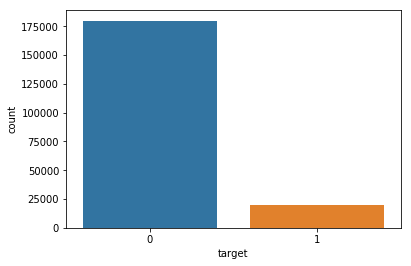

In [3]:
#view Data shape
print(train_data.shape,test_data.shape)
#check for missing values
print(train_data.isnull().values.any(),test_data.isnull().values.any())
#check data correlation 
print(train_data.corr())
#Visualize class distribution
sns.countplot(train_data['target'])

**Deductions from the above**
- There are no missing vallues in either the test or train sets
- The train set contains an extra column which is the known target to be used in training our model
- There is no correlation between the features in the train dataset
- There is a significant class imbalance between the 0s and 1s

The percentage of each class is calculated in the cell below

In [4]:
# check class distribution in percentage
count_0 = len(train_data[train_data["target"] == 0])
count_1 = len(train_data[train_data["target"] == 1])
percentage_count_0 = ((count_0)/(count_0+count_1)) * 100
percentage_count_1 = 100-percentage_count_0
print("{}{}{}{}{}".format("Percentage of 0 class is ",percentage_count_0,"\n","Percentage of 1 class is ",percentage_count_1))


Percentage of 0 class is 89.95100000000001
Percentage of 1 class is 10.048999999999992


**Split train_data into train and validation sets**

In [5]:
labels = train_data["target"]
new_train_data = train_data.drop(["target","ID_code"],axis =1)
new_train_data.head()
x_train, x_test, y_train, y_test = train_test_split(new_train_data, labels, test_size = 0.25, random_state = 0)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
x_train.head()

(150000, 200) (50000, 200)
(150000,) (50000,)


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
105800,7.1710,0.0780,9.7313,5.2754,8.4569,1.0961,5.6193,19.7863,-3.0315,6.8223,2.5263,4.9981,13.9677,6.8061,4.7322,14.1186,9.0974,-11.2240,17.9139,11.0509,14.7752,32.8374,10.2966,3.4888,6.2547,13.5648,-5.7459,-0.6498,4.3383,4.7462,-13.1613,10.5528,-0.7888,11.6772,11.2966,7.9723,5.8383,8.4460,13.3923,-4.4930,...,30.4980,5.7451,4.6325,5.0144,1.4196,23.7389,2.6750,-1.3684,7.6428,5.7646,-3.8745,-10.4765,25.1012,-9.9958,27.2812,6.2933,-15.8091,10.4539,-9.3122,2.8948,-4.8210,8.4080,5.0552,16.9429,14.0333,2.5933,12.6163,-7.2145,12.9924,1.2416,1.3701,9.9152,2.0668,5.3564,21.6815,-0.1577,-1.3003,8.4862,16.8159,-7.3853
27538,12.9988,-0.8167,9.0578,6.1068,9.0826,-20.3450,7.3668,20.5931,4.4952,8.3794,-2.6283,-11.5343,14.2105,6.3588,10.6629,14.2864,6.1238,3.2445,6.4376,6.2494,20.0997,20.3825,3.5640,3.8544,11.0345,13.3940,6.4604,-1.3166,5.8386,5.3434,-15.8937,9.8919,-3.7623,10.7072,12.2440,13.1534,7.4214,2.3099,11.0870,4.6868,...,46.0527,5.8512,4.7978,6.5647,-7.1101,29.4211,2.4211,-10.6893,2.5800,5.5625,-6.7060,1.6756,13.2715,3.4671,31.7427,15.9629,4.2036,9.1558,17.3793,1.3517,-4.4944,7.8056,7.4971,9.1212,22.2043,4.3224,2.9281,-10.8262,18.4998,0.1512,2.2635,9.9614,0.9975,4.2109,19.2522,-0.2888,2.2767,8.4979,13.6564,-1.1474
108979,11.2861,-0.2255,17.2522,5.8849,13.0078,4.0183,5.0971,11.4301,-1.7817,6.3523,-0.7780,-10.6161,13.5544,13.9533,7.2666,15.0989,5.8719,-14.9021,22.0891,15.5638,4.7581,21.1650,9.3463,2.1115,13.6982,13.8076,-4.5608,-3.5556,4.6642,6.1699,4.9259,11.3081,-3.9430,8.0641,12.2030,3.5548,2.7875,5.8096,16.6633,4.7082,...,33.3342,6.0394,2.9413,12.9801,1.5205,20.0853,2.8947,-19.3527,5.2126,5.4197,-3.7771,-3.8371,24.2803,-9.2187,19.6684,10.6127,-0.9008,11.7708,3.7611,1.9704,-8.2891,10.3222,6.8423,8.2890,16.0035,-3.2908,13.5046,-14.7954,13.5966,2.4556,7.1895,11.7965,2.2497,10.9765,18.8830,1.0117,1.8379,7.3530,13.5594,6.4416
184818,13.4434,-5.7222,13.4512,4.7605,14.5425,2.6660,5.8011,19.3957,1.4480,7.6016,-4.4300,-15.8139,14.1223,16.3147,11.0964,14.6087,5.8165,-10.2562,13.8512,13.7855,10.0983,36.3466,1.5583,1.9625,7.2798,13.4934,-5.1827,1.0547,5.8489,1.3562,5.1330,10.9412,2.1192,16.5629,11.5814,-0.9995,7.5970,7.3915,11.5300,-4.0754,...,21.7864,5.7288,4.0159,5.6799,-2.0304,20.9787,2.8468,4.4427,5.2771,5.2363,1.5659,2.1499,19.3227,5.1222,21.8927,13.8721,-21.4911,13.3503,-4.5672,4.9113,-0.3818,11.2787,-15.2789,4.9551,1.3241,-5.3471,8.9914,-7.6601,15.2406,0.1046,-2.5342,6.7572,4.1626,1.5798,18.3637,1.7772,9.0057,8.5145,18.6113,3.9470
121763,7.3488,3.2396,12.8417,8.3421,12.0869,-0.3122,4.1239,11.7267,0.8601,9.4517,7.5351,-13.3338,14.0258,5.2542,8.0364,14.3044,5.5817,-8.9936,3.5019,-0.2994,24.0453,17.4334,6.9780,3.9353,7.8424,13.8977,10.1185,0.5483,4.6773,8.3812,-8.9568,13.4227,3.3882,10.4680,11.5528,10.8748,-0.3079,6.2513,13.9002,0.5789,...,49.2054,5.2230,5.7743,15.5129,1.0193,18.2324,2.7537,-7.4034,5.0998,5.4153,3.5544,2.3753,8.7023,1.4464,16.7936,6.2366,-7.3021,9.3020,-3.4587,3.6592,1.6869,6.3266,-8.0208,6.0773,1.4794,-3.7113,9.1823,-23.1275,17.4792,1.6969,6.8424,3.1530,2.0189,3.3557,22.6439,0.2648,0.3030,8.0920,16.3242,-10.1387


Use StratifiedKFold to ensure test and train datasets contains equal percentage of both classes

In [6]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=2319)
param = {
    'bagging_freq': 5, 
    'bagging_fraction': 0.33,
    'boost_from_average':'false',   
    'boost': 'gbdt',
    'feature_fraction': 0.0405,
    'learning_rate': 0.083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,     
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 4,            
    'tree_learner': 'serial',
    'objective': 'binary',
    'verbosity': 1
}
oof = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))
features = [c for c in train_data.columns if c not in ['ID_code', 'target']]
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_data.values, labels.values)):
    trn_data = lgb.Dataset(train_data.iloc[trn_idx][features], label=labels.iloc[trn_idx])
    val_data = lgb.Dataset(train_data.iloc[val_idx][features], label=labels.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train_data.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_data[features], num_iteration=clf.best_iteration) / folds.n_splits


Training until validation scores don't improve for 4000 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.936435	valid_1's auc: 0.894534
Training until validation scores don't improve for 4000 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.936193	valid_1's auc: 0.893918
Training until validation scores don't improve for 4000 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.93693	valid_1's auc: 0.887632
Training until validation scores don't improve for 4000 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.936294	valid_1's auc: 0.892666
Training until validation scores don't improve for 4000 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.936533	valid_1's auc: 0.896788
Training until validation scores don't improve for 4000 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.936112	valid_1's auc: 0.

In [7]:
target = train_data.iloc[val_idx]['target']
print("\n >> CV score: {:<8.5f}".format(roc_auc_score(target, oof[val_idx])))



 >> CV score: 0.89526 


In [8]:
ID_code = test_data["ID_code"]
submission = pd.DataFrame({'ID_code' : ID_code,
                            'target' : predictions})
submission.to_csv('./version1.csv', index=False)
sub = pd.read_csv('./version1.csv')
sub.head()

,ID_code,target
0,test_0,0.117333
1,test_1,0.212773
2,test_2,0.211517
3,test_3,0.226387
4,test_4,0.030008
